# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-07-20.ipynb)

## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 20. Textual Inversion

Textual Inversion [[Gal+ ICLR'23]](https://arxiv.org/abs/2208.01618) を用いて Stable Diffusion に新しい概念（コンセプト; concept）を「教える」方法を紹介します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Tue Jul  4 12:49:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
  - [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
  - [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00


## Textual Inversion

本セクションでは [`Textual-inversion fine-tuning for Stable Diffusion using d🧨ffusers`](https://github.com/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb) を参考に、textual inversion の動作を追っていきます。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### 新たな概念をモデルに教えるための設定

使用する事前学習済み拡散モデルを指定します。今回は [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) を選択しました。

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"

Google drive にデータを保存する設定を行います。`File` タブから google drive に用意した画像を読み込むことも可能ですが、今回は google drive をマウントし、そこから drive 上に保存した画像を読み込む方法を検討します。

In [ ]:
import os
from google.colab import drive

# /content/drive をマウントする
DRIVE_PATH = os.path.join(os.sep, "content", "drive")
print(f"Mount the following directories: {DRIVE_PATH}")

drive.mount(DRIVE_PATH)

#
# 本 notebook 用のデータを格納するディレクトリを作成する
# まずベースとなるディレクトリとして以下のようなディレクリを作成する:
# /content/drive/MyDrive/colab-notebooks/oloso/practice
#
base_dir_path = os.path.join(DRIVE_PATH, "MyDrive", "colab-notebooks", "coloso", "practice")
#
# 次に講義用のディレクトリを作成する。今回は第 20 講なので `lecture-20` と命名する:
# /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20
#
lecture_dir_path = os.path.join(base_dir_path, "lecture-20")

#
# 今回使用する学習画像を保存するディレクトリを作成する:
# /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images
#
sample_image_dir_path = os.path.join(lecture_dir_path, "sample-images")
print(f"The images will be saved in the following path: {sample_image_dir_path}")

# 上記のディレクトリが存在しない場合は作成する
if not os.path.exists(sample_image_dir_path):
    os.makedirs(sample_image_dir_path)

Mount the following directories: /content/drive
Mounted at /content/drive
The images will be saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images


学習に使用するデータを用意します。今回は textual inversion にも登場している猫のおもちゃを [huggingface dataset](https://huggingface.co/datasets/diffusers/cat_toy_example) 上からダウンロードしてきます。ここではまず Colab 上でダウンロードしたのちに、google drive に保存する方法を取ります。以下の `urls` に学習したい概念の画像の URL を追加してください。textual inversion は数枚の画像で学習が可能であるため、3 〜 5 枚で十分です。

In [ ]:
urls = [
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/1.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/2.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/3.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/4.jpeg",
    #
    # ここに更に画像を追加することができます
    #
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/5.jpeg",
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/6.jpeg",
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/7.jpeg",
]

オンラインにある画像をダウンロードする関数を以下のように定義します。この関数を使って上記の `urls` で指定した画像をインターネット上からダウンロードします。

In [ ]:
import requests

def download_image(url: str) -> PilImage:
    return Image.open(requests.get(url, stream=True).raw)

for i, url in enumerate(urls):
    image = download_image(url)
    image_filepath = os.path.join(sample_image_dir_path, f"{i}.jpg")
    print(f"The image is saved in the following path: {image_filepath}")
    image.save(image_filepath)

The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images/0.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images/1.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images/2.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sample-images/3.jpg


準備した画像を確認してみます。

In [ ]:
images: List[PilImage] = []
for file_path in os.listdir(sample_image_dir_path):
    image_filepath = os.path.join(sample_image_dir_path, file_path)
    image = Image.open(image_filepath)
    image = image.resize((512, 512))
    images.append(image)

image_grid(images, rows=1, cols=len(images))

Output hidden; open in https://colab.research.google.com to view.

学習したい概念に対する textual inversion の設定を行います。
- `what_to_teach` には生成モデルに何を教えるかを指定します。教える対象として`object` と`style` が選択肢としてあります。
- `placeholder_token` には新しい概念を表現するために使用するトークンを指定します。モデルに入力するプロンプトを指定する際は "遊園地の `placeholder_token`" のように指定します。この特別なトークンは他の単語やトークンと区別するために角括弧を使用して指定してください。
- `initializer_token` には新しい概念が何であるかを要約する単語を指定します。この単語が `placeholder_token` を学習する出発点となります。できるだけ類似する単語を選択してください。

In [ ]:
from typing import Literal, get_args

# モデルに教える特性の選択肢を定義します。ここでは object と style が選択可能
LearnableProperty = Literal["object", "style"]

# モデルに何を教えるかを指定
what_to_teach = "object"

# 新しい概念を表現するために使用するトークンを指定
placeholder_token = "<toy-cat>"

# 新しい概念に関連する単語を指定
initializer_token = "toy" # 今回の場合は cat でもいいかもしれません

# `what_to_teach` を正しく設定できているか確認します
if not what_to_teach in get_args(LearnableProperty):
    raise ValueError(
        f"Invalid learnable property: {what_to_teach}. "
        f"You should choose from the following options: {get_args(LearnableProperty)}."
    )

### Textual Inversion による新たな概念の学習

以下の一連のセルを実行して学習を開始させます。全工程で 1 〜 4 時間程度かかるかもしれません。まずはデータセットの加工を行っていきます。

学習用のプロンプトテンプレートを準備します。これらは textual inversion の論文 [[Gal+ ICLR'23]](https://arxiv.org/abs/2208.01618) を参考に定義されています。

In [ ]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

学習データの読み込みと加工を担う `torch.utils.data.Dataset` クラスを元にした `TextualInversionDataset` を定義します。

In [ ]:
import PIL
import random

import numpy as np
import torch

from typing import TypedDict

from torch.utils.data import Dataset
from torchvision import transforms
from transformers.tokenization_utils import PreTrainedTokenizer

# 画像の拡大縮小方法の選択肢を定義
InterpolationType = Literal["linear", "bilinear", "bicubic", "lanczos"]
INTERPOLATION = {
    "linear": PIL.Image.LINEAR,
    "bilinear": PIL.Image.BILINEAR,
    "bicubic": PIL.Image.BICUBIC,
    "lanczos": PIL.Image.LANCZOS,
}

#
# 加工したデータセットを辞書型のデータに加工する際に
# key の定義と対応する value の型アノテーションを宣言
#
# 以下のように宣言することで、想定とは異なるデータが
# 入ってきた場合にエラーを出すことができる
#
class Example(TypedDict):
    input_ids: torch.Tensor
    pixel_values: torch.Tensor

#
# 読み込んだデータセットを加工する Dataset クラス
#
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root: str,
        tokenizer: PreTrainedTokenizer,
        learnable_property: LearnableProperty,
        image_size: int = 512,
        repeats: int = 100,
        interpolation: InterpolationType = "bicubic",
        flip_proba: float = 0.5,
        split: str = "train",
        placeholder_token: str = "*",
        is_center_crop: bool = False,
    ) -> None:
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.image_size = image_size
        self.placeholder_token = placeholder_token
        self.is_center_crop = is_center_crop
        self.flip_proba = flip_proba

        self.image_paths = [
            os.path.join(self.data_root, file_path)
            for file_path in os.listdir(self.data_root)
        ]

        self.num_images = len(self.image_paths)
        self.dataset_length = (
            self.num_images * repeats
            if split == "train"
            else self.num_images
        )

        self.interpolation = INTERPOLATION[interpolation]

        self.templates = (
            imagenet_style_templates_small
            if learnable_property == "style"
            else imagenet_templates_small
        )

        self.flip_transform = transforms.RandomHorizontalFlip(self.flip_proba)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Example:
        # 画像のパスから画像を読み込み
        image_pil = Image.open(self.image_paths[idx % self.num_images])

        if not image.mode == "RGB":
            image_pil = image_pil.convert("RGB")

        placeholder_string = self.placeholder_token
        # 上記で定義したプロンプトのテンプレートリストからランダムに
        # 1 つ取ってきて、placeholder_string を埋め込む
        text = random.choice(self.templates).format(placeholder_string)

        # tokenizer で文章をトークン列に変換
        input_ids = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        ).input_ids[0]

        image_arr = np.array(image_pil).astype(np.uint8)

        if self.is_center_crop:
            crop = min(*image_arr.shape)
            h, w, = (
                image_arr.shape[0],
                image_arr.shape[1],
            )
            image_arr = image_arr[
                (h - crop) // 2:(h + crop) // 2,
                (w - crop) // 2:(w + crop) // 2
            ]

        image_pil = Image.fromarray(image_arr)
        image_pil = image_pil.resize(
            (self.image_size, self.image_size),
            resample=self.interpolation
        )

        image_pil = self.flip_transform(image_pil)
        image_arr = np.array(image_pil).astype(np.uint8)
        image_arr = (image_arr / 127.5 - 1.0).astype(np.float32)

        pixel_values = torch.from_numpy(image_arr).permute(2, 0, 1)

        return {"input_ids": input_ids, "pixel_values": pixel_values}

モデルをセットアップしていきます。まずは文をトークンに分割する `tokenizer` を読み込みます。その後 `placeholder_token` を追加の special token として設定します。

In [ ]:
from transformers import CLIPTokenizer

# tokenizer の読み込み
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# `placeholder_token` と tokenizer に追加
num_added_tokens = tokenizer.add_tokens(placeholder_token)

if num_added_tokens == 0:
    #
    # `placeholder_token` が元々 `tokenizer` に含まれていたらエラーを出す
    # エラーになったら違う `placeholder_token` を指定するようにしてください
    #
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. ",
        "Please pass a difference `placeholder_token` that is not already in the tokenizer."
    )

`placeholder_token` と `initializer_token` のトークン ID を取得します。`initializer_token` が単一のトークンでない場合にエラーが出ます。

In [ ]:
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

Stable Diffusion で学習されたコンポーネントをそれぞれ読み込みます。

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

`tokenizer` に `placeholder_token` を追加したため、`text_encoder` が持つ埋め込み層のパラメータを拡張します。

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

上記で拡張した `placeholder_token` 用のパラメータを、`initializer_token` のパラメータで初期化します。

こうした操作を行うため、新たに学習させたい概念と対応している `placeholder_token` に近い概念を `initializer_token` に設定していただきたいです。

In [ ]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

Textual Inversion では、新しく追加されたパラメータのみを学習させます。以下ではそれ以外のパラメータを固定 (freeze) させます。

In [ ]:
import itertools
import torch.nn as nn

from typing import Iterable

def freeze_params(params: Iterable[nn.Parameter]) -> None:
    for param in params:
        param.requires_grad = False

# VAE と U-Net のパラメータを固定
freeze_params(vae.parameters())
freeze_params(unet.parameters())

# Text Encoder において、追加したパラメータ以外を固定
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

学習用データを、上記で定義した `TextualInversionDataset` を元に作成します。

In [ ]:
train_dataset = TextualInversionDataset(
    data_root=sample_image_dir_path,
    tokenizer=tokenizer,
    image_size=vae.config.sample_size,
    placeholder_token=placeholder_token,
    repeats=100,
    learnable_property=what_to_teach, # 学習させたい概念の種類（object/style）を指定
    is_center_crop=False,
    split="train",
)

学習時に付与するノイズを制御するスケジューラを定義します。

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

学習の準備を行います。ハイパーパラメータを以下のように定義します。モデルを学習して生成結果を確認したときに結果が悪かった場合は `learning_rate` や `max_train_steps` の調整を検討してみてください。

In [ ]:
from dataclasses import dataclass

@dataclass
class Hyperparameter(object):
    learning_rate: float = 5e-4
    scale_lr: bool = True
    max_train_steps: int = 2000 # デフォルトは 2000 程度
    save_steps: int = 250
    train_batch_size: int = 4
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    mixed_precision: str = "fp16"
    seed: int = 19950815
    output_dir_path: str = os.path.join(lecture_dir_path, "sd-concept-output")

hparams = Hyperparameter()
print(hparams)

print(f"The training results are saved in the following directory: {hparams.output_dir_path}")
if not os.path.exists(hparams.output_dir_path):
    os.makedirs(hparams.output_dir_path)

Hyperparameter(learning_rate=0.0005, scale_lr=True, max_train_steps=2000, save_steps=250, train_batch_size=4, gradient_accumulation_steps=1, gradient_checkpointing=True, mixed_precision='fp16', seed=19950815, output_dir_path='/content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sd-concept-output')
The training results are saved in the following directory: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/sd-concept-output


学習の途中結果を保存する関数を以下のように定義します。

In [ ]:
from accelerate import Accelerator
from accelerate.logging import get_logger

logger = get_logger(__name__)

def save_progress(text_encoder: CLIPTextModel, placeholder_token_id: int, accelerator: Accelerator, save_path: str) -> None:
    logger.info("Saving embeddings")

    # 新たに追加した概念に対応する埋め込みベクトルのみを保存する
    # `placeholder_token` の ID を指定することで対象のベクトルを取得可能
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}

    torch.save(learned_embeds_dict, save_path)

学習ループを司る `training_function` を定義します。

In [ ]:
import math
import torch.nn.functional as F

from diffusers import StableDiffusionPipeline
from tqdm.auto import tqdm

def training_function(text_encoder: CLIPTextModel, vae: AutoencoderKL, unet: UNet2DConditionModel):
    # ハイパーパラメータの値を取得
    train_batch_size = hparams.train_batch_size
    gradient_accumulation_steps = hparams.gradient_accumulation_steps
    learning_rate = hparams.learning_rate
    max_train_steps = hparams.max_train_steps
    output_dir_path = hparams.output_dir_path
    gradient_checkpointing = hparams.gradient_checkpointing

    # 学習を効率化する Accelerator の設定
    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hparams.mixed_precision,
    )

    # GPU メモリの使用を抑える Gradient Checkpointing の設定
    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    # 学習用のデータローダーの設定
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    if hparams.scale_lr:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # 最適化手法を初期化
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # 追加した placeholder_token の部分のみ学習
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # GPU へ VAE と U-Net を移動させます
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # VAE は学習させないため eval モードに
    vae.eval()
    # U-Net は gradient checkpointing を有効にするため train モードに
    unet.train()

    # 学習用データローダーのサイズが gradient accumulation の数によって変わる可能性があるため
    # ここで再度学習ステップ数を計算し直す
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")

    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # 画像を潜在データへ変換
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # 潜在データへ追加するノイズを取得
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # 各画像に対してランダムなタイムステップ数を取得
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()

                # 各タイムステップにおけるノイズの大きさに従って
                # 潜在データにノイズを追加（拡散過程）
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 条件付けのためにプロンプトからテキストベクトルを取得
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # ノイズを予測
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                # 予測タイプに応じた損失を計算
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # 概念の埋め込みだけを最適化したいので、
                # 新しく追加された概念の埋め込み以外のすべてのトークンの埋め込みに対する勾配をゼロに
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # 勾配をゼロにする対象のインデックスを取得
                # `placeholder_token_id` 以外のものを選択することで達成
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # accelerator がバックグラウンドで最適化工程を実行したかを確認
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hparams.save_steps == 0:
                    save_path = os.path.join(hparams.output_dir_path, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()

    # 学習したモデルを元に、pipeline を構築して保存
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(hparams.output_dir_path)
        # 新たに追加した概念に対応するパラメータも保存
        save_path = os.path.join(hparams.output_dir_path, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

`accelerate` を用いて Colab notebook 上で効率的な学習を開始します。

In [ ]:
import accelerate

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad # Colab では RAM の制約があるため勾配に関する情報を削除
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
hparams.output_dir_path = "drive/MyDrive/colab-notebooks/coloso/practice/lecture-20/pre-trained/"

### 学習した概念を元に画像を生成する

上記で学習した結果を `StableDiffusionPipeline` で読み込んで、`placeholder_token` を含んだプロンプトで新たな画像を生成させてみましょう。

In [ ]:
from diffusers import DPMSolverMultistepScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained(hparams.output_dir_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    hparams.output_dir_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

`placeholder_token` として設定した `<cat-toy>` を含んだプロンプトを指定して画像を生成させてみます。

  0%|          | 0/25 [00:00<?, ?it/s]

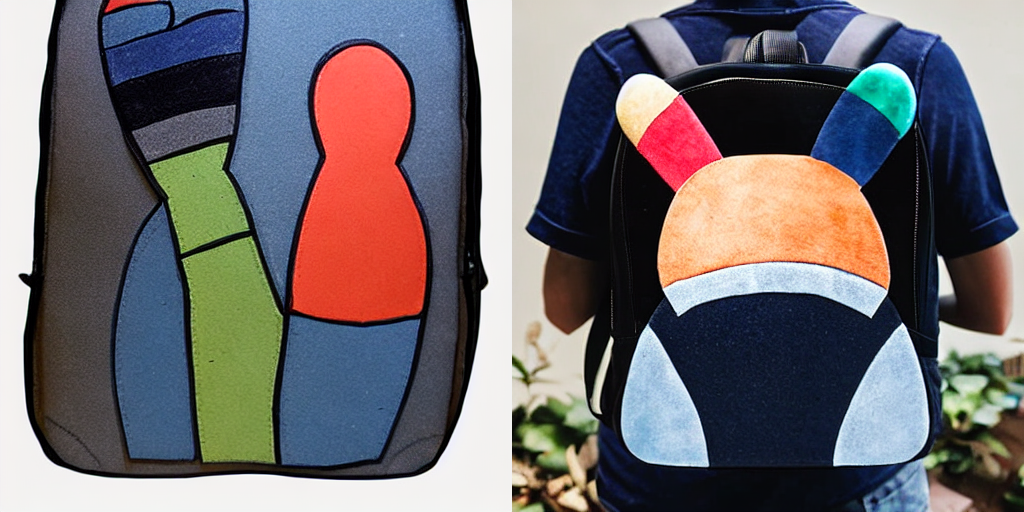

In [ ]:
prompt = "A <cat-toy> backpack"

num_samples = 2
num_rows = 1

# 結果を再現できるように乱数の seed を固定
generator = torch.Generator().manual_seed(42)

all_images = []
for _ in range(num_rows):
    images = pipe(
        prompt,
        num_images_per_prompt=num_samples,
        generator=generator,
        num_inference_steps=25,
    ).images
    all_images.extend(images)

image_grid(all_images, num_rows, num_samples)

In [ ]:
image_grid(images, rows=1, cols=len(images))

Output hidden; open in https://colab.research.google.com to view.

モデルに与えたわずか**数枚**の画像から、そのコンセプトを捉えた画像が生成できました。